## **Abbandono scolastico**

Il dataset *Abbandono scolastico* contiene **100.000 osservazioni** relative a studenti delle scuole secondarie, generate in modo realistico per analizzare i fattori che influenzano la **probabilità di abbandono scolastico**.

Ogni riga rappresenta uno studente ed è descritta da **14 caratteristiche** di tipo scolastico, socio-economico e personale:

- **Assenze:** numero di giorni di assenza nell’anno scolastico.  
- **Voti_medi:** media dei voti scolastici (da 2 a 10).  
- **Ripetenze:** numero di anni scolastici ripetuti.  
- **Cambi_scuola:** numero di cambi di istituto o trasferimenti.  
- **ISEE:** indicatore della situazione economica equivalente del nucleo familiare.  
- **Lavoro_genitori:** situazione occupazionale dei genitori (entrambi, uno, precari, nessuno).  
- **Residenza:** tipo di area abitativa (urbana, periferia, rurale).  
- **Età:** età dello studente in anni.  
- **Genere:** maschile o femminile.  
- **Titolo_studio_genitori:** livello d’istruzione più alto tra i genitori.  
- **Reddito_familiare:** reddito complessivo annuo della famiglia.  
- **Distanza_scuola_km:** distanza stimata tra casa e scuola in chilometri.  
- **Partecipazione_ore_sett:** ore settimanali dedicate ad attività extracurriculari o progetti scolastici.  
- **Condotta:** valutazione del comportamento scolastico (da 3 a 10).  

La colonna **Abbandonato** è la **variabile target**, e indica se lo studente ha **abbandonato la scuola (1)** o **proseguito gli studi (0)**.


## 1) Caricamento e preparazione del dataset

In [9]:
import pandas as pd

bad_lines = []

def bad_line_handler(line):
    bad_lines.append(line)
    return None  # salta la riga problematica

df = pd.read_csv("abbandono_scolastico_100k.csv",
                 on_bad_lines=bad_line_handler,
                 engine="python")

print("Righe lette correttamente:", df.shape[0])
print("Righe problematiche:", len(bad_lines))

if bad_lines:
    print("\nEsempio di riga corrotta:\n", bad_lines[0][:200])


Righe lette correttamente: 46319
Righe problematiche: 0


##2) Analisi eplorativa



In [10]:
import pandas as pd

# Normalizza nomi colonne
df.columns = df.columns.str.strip()

#Controlla che la colonna target esista
target_col = "abbandonato"
if target_col not in df.columns:
    raise ValueError(f"Target '{target_col}' non trovato. Colonne disponibili: {list(df.columns)}")

# Controlla valori mancanti e duplicati
na_count = df.isna().sum().sum()
dup_count = df.duplicated().sum()
print(f"NA totali: {na_count}  |  Duplicati: {dup_count}")

# Statistiche descrittive per variabili numeriche
num_df = df.select_dtypes(include=['number'])
cat_df = df.select_dtypes(exclude=['number'])
print("\nStatistiche numeriche:")
display(num_df.describe().T)

print("\nStatistiche categoriali:")
display(cat_df.describe().T)
#Distribuzione classi (target)
print("\nDistribuzione classi:")
display(df[target_col].value_counts(normalize=True).mul(100).round(2).to_frame("%"))



NA totali: 9  |  Duplicati: 0

Statistiche numeriche:


count          mean           std      min  \
abbandonato              46319.0      0.310909      0.462871     0.00   
assenze                  46319.0     19.935189      8.959930     0.00   
voti_medi                46319.0      6.748280      1.196294     2.03   
ripetenze                46319.0      0.238023      0.464853     0.00   
cambi_scuola             46319.0      0.297696      0.518829     0.00   
isee                     46319.0  18108.480429   8753.047348     1.00   
eta                      46318.0     16.511127      1.486216    13.00   
reddito_familiare        46318.0  26297.160953  13346.796837  1101.00   
distanza_scuola_km       46318.0      3.023088      2.481642     0.20   
partecipazione_ore_sett  46318.0      2.823252      1.923123     0.00   
condotta                 46318.0      7.472324      1.199664     3.00   

                              25%       50%       75%      max  
abbandonato                  0.00      0.00      1.00      1.0  
assenze                     14.00     18.00     26.00     68.0  
voti_medi                    5.94      6.75      7.56     10.0  
ripetenze                    0.00      0.00      0.00      3.0  
cambi_scuola                 0.00      0.00      1.00      3.0  
isee                     11899.50  18028.00  24097.50  58312.0  
eta                         15.50     16.50     17.50     21.0  
reddito_familiare        16841.00  25629.00  35029.00  93362.0  
distanza_scuola_km           1.30      2.30      4.00     25.7  
partecipazione_ore_sett      1.30      2.70      4.10     11.4  
condotta                     6.70      7.50      8.30     10.0


Statistiche categoriali:


count unique       top   freq
lavoro_genitori         46318      4  entrambi  20763
residenza               46318      3    urbana  25458
genere                  46318      2         M  24240
titolo_studio_genitori  46318      4   diploma  17603


Distribuzione classi:


%
abbandonato       
0            68.91
1            31.09

##Correlazione tra feature


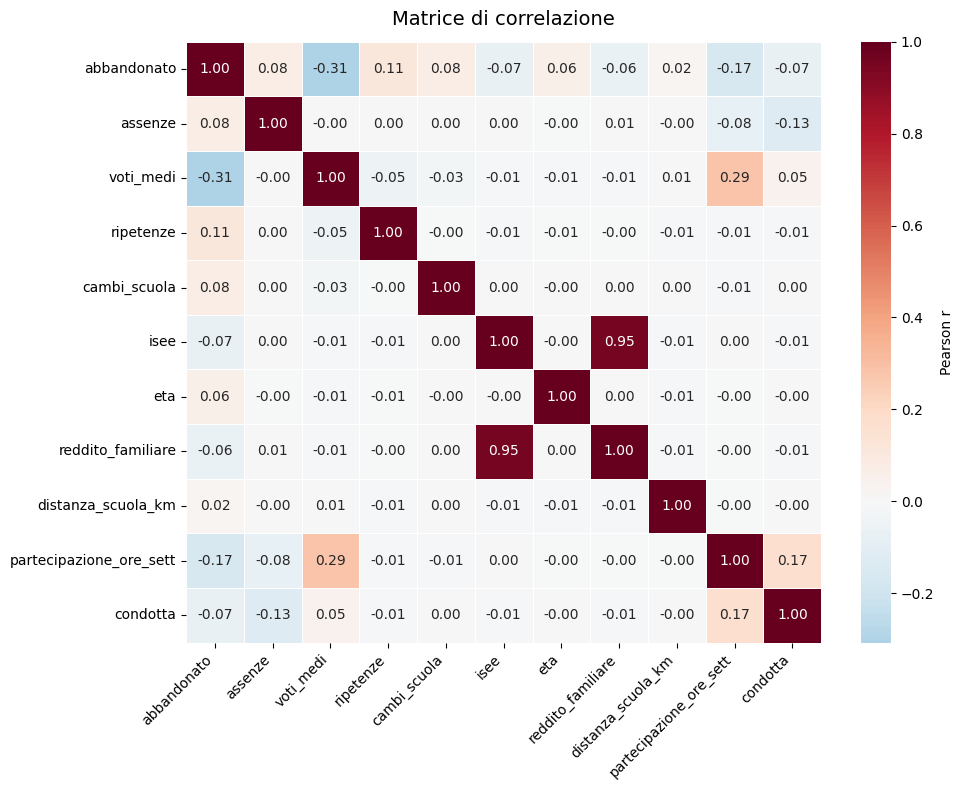

In [11]:

import seaborn as sns
import matplotlib.pyplot as plt

# Seleziona solo le colonne numeriche
num_df = df.select_dtypes(include=['number'])

# Calcola la matrice di correlazione
corr_matrix = num_df.corr()

# Crea la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Pearson r'}
)

plt.title("Matrice di correlazione", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##Distribuzione delle feature per classe

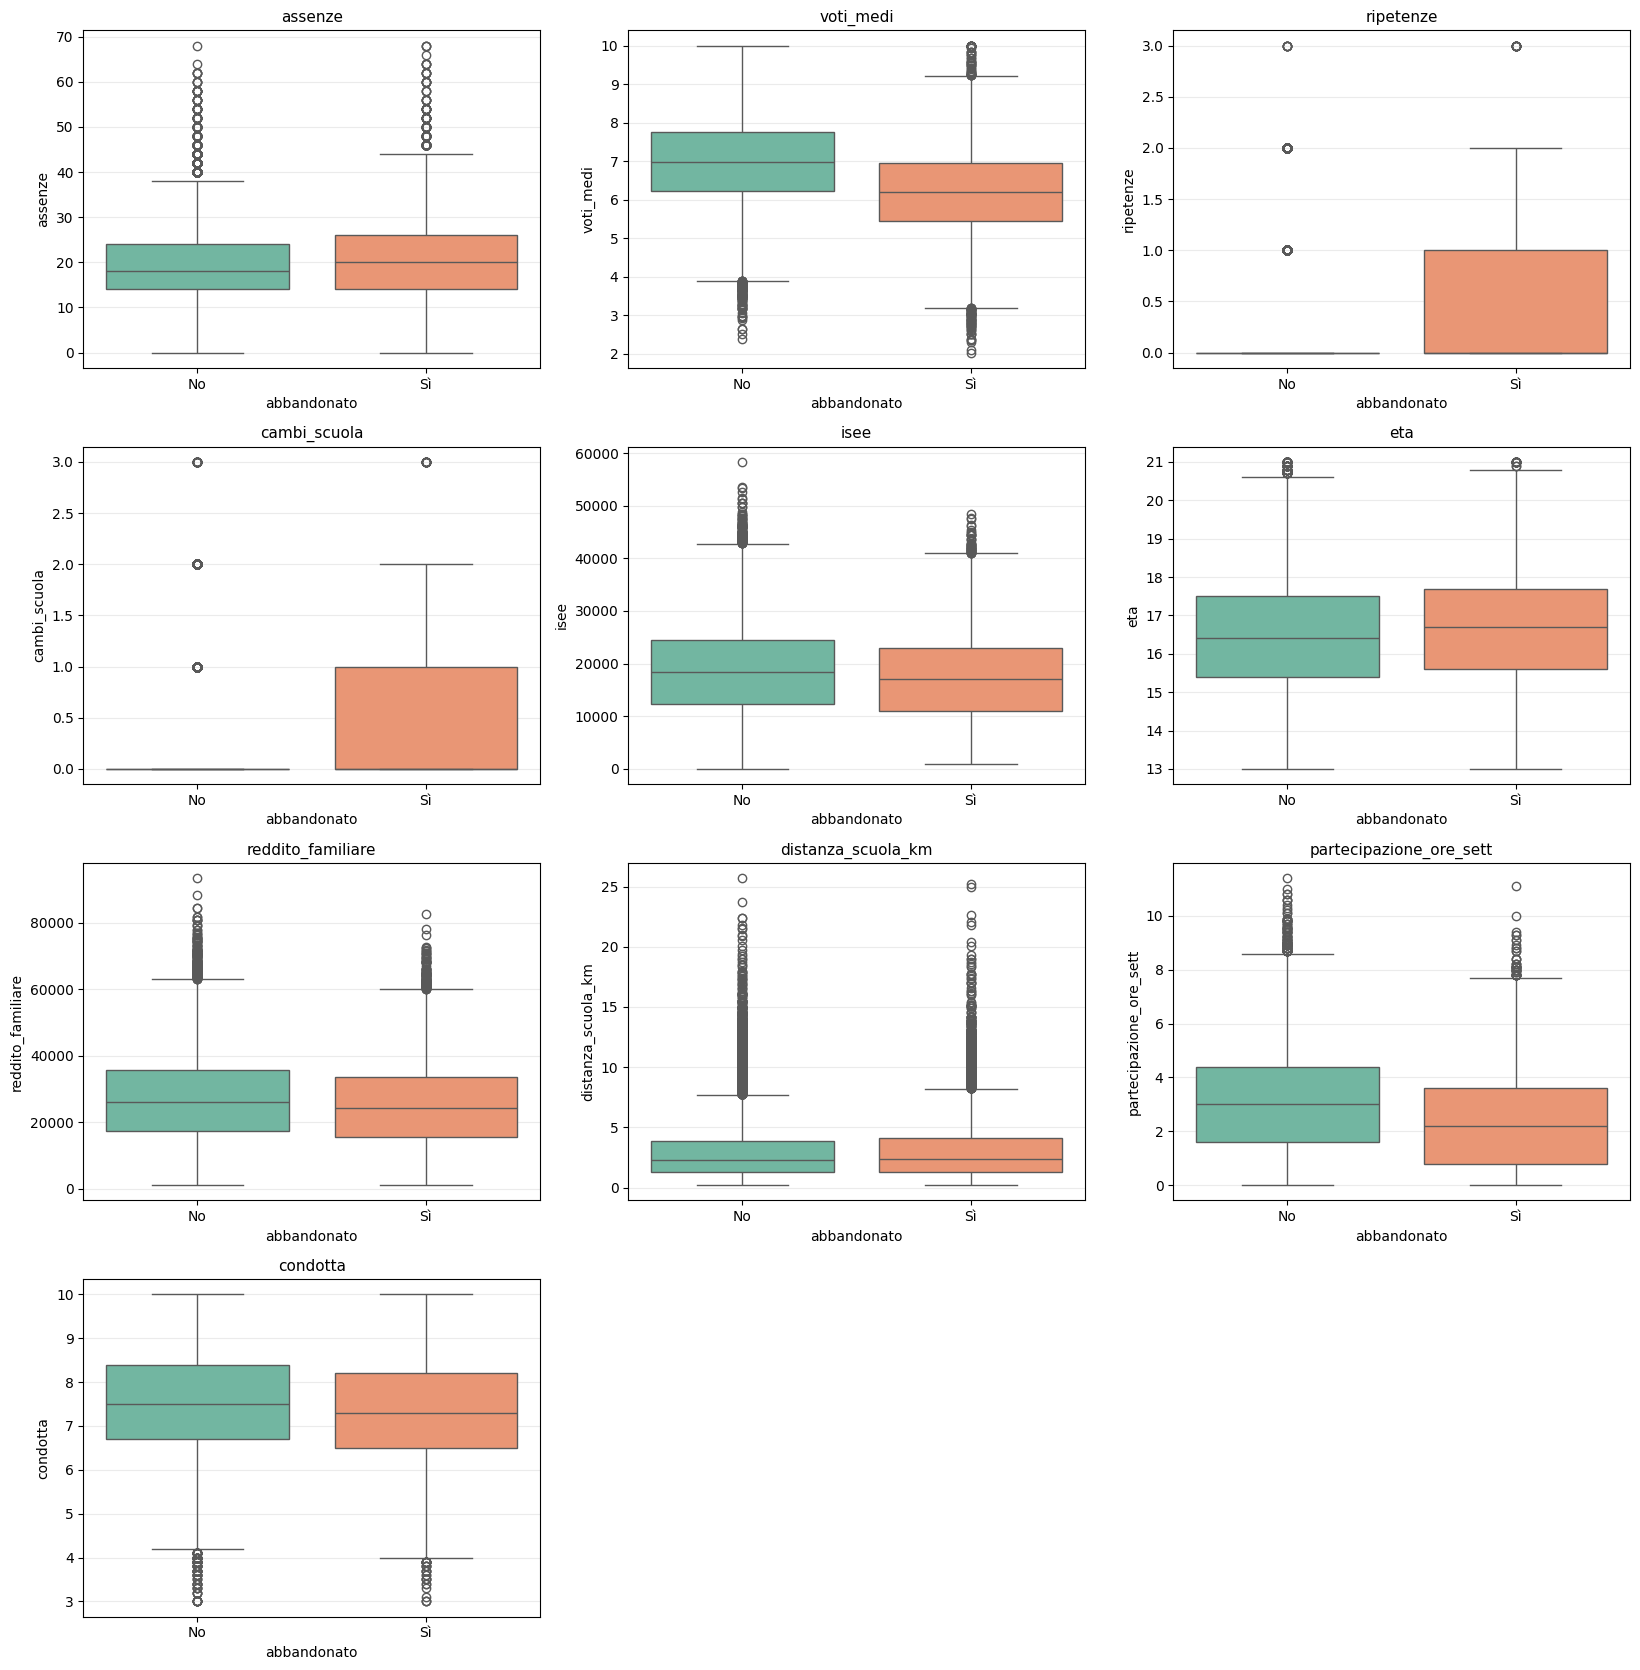

In [12]:

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---- parametri
target = "abbandonato"          # "abbandonato"
n_cols = 3                # numero di colonne nella griglia

# ---- prepara target per il plotting (gestisce 0/1)
df_plot = df.copy()
if target not in df_plot.columns:
    raise ValueError(f"Target '{target}' non trovato. Colonne: {list(df_plot.columns)}")

if not pd.api.types.is_object_dtype(df_plot[target]) and df_plot[target].nunique() <= 5:
    # mappa 0/1 in etichette leggibili
    mapping = {0: "No", 1: "Sì"}
    df_plot[target] = df_plot[target].map(mapping).fillna(df_plot[target].astype(str))

# ---- seleziona solo feature numeriche (esclude il target se numerico)
num_cols = df_plot.select_dtypes(include=["number"]).columns.tolist()
if target in num_cols:
    num_cols.remove(target)

# ---- griglia
n_rows = math.ceil(len(num_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.5*n_cols, 4.2*n_rows))
axes = np.array(axes).ravel()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.boxplot(data=df_plot, x=target, y=col, ax=ax, hue=target, legend=False, palette="Set2")
    ax.set_title(col, fontsize=11)
    ax.set_xlabel(target)
    ax.set_ylabel(col)
    ax.grid(axis="y", alpha=0.25)

# spegni assi vuoti
for ax in axes[len(num_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


##Distribuzione delle feature per classe

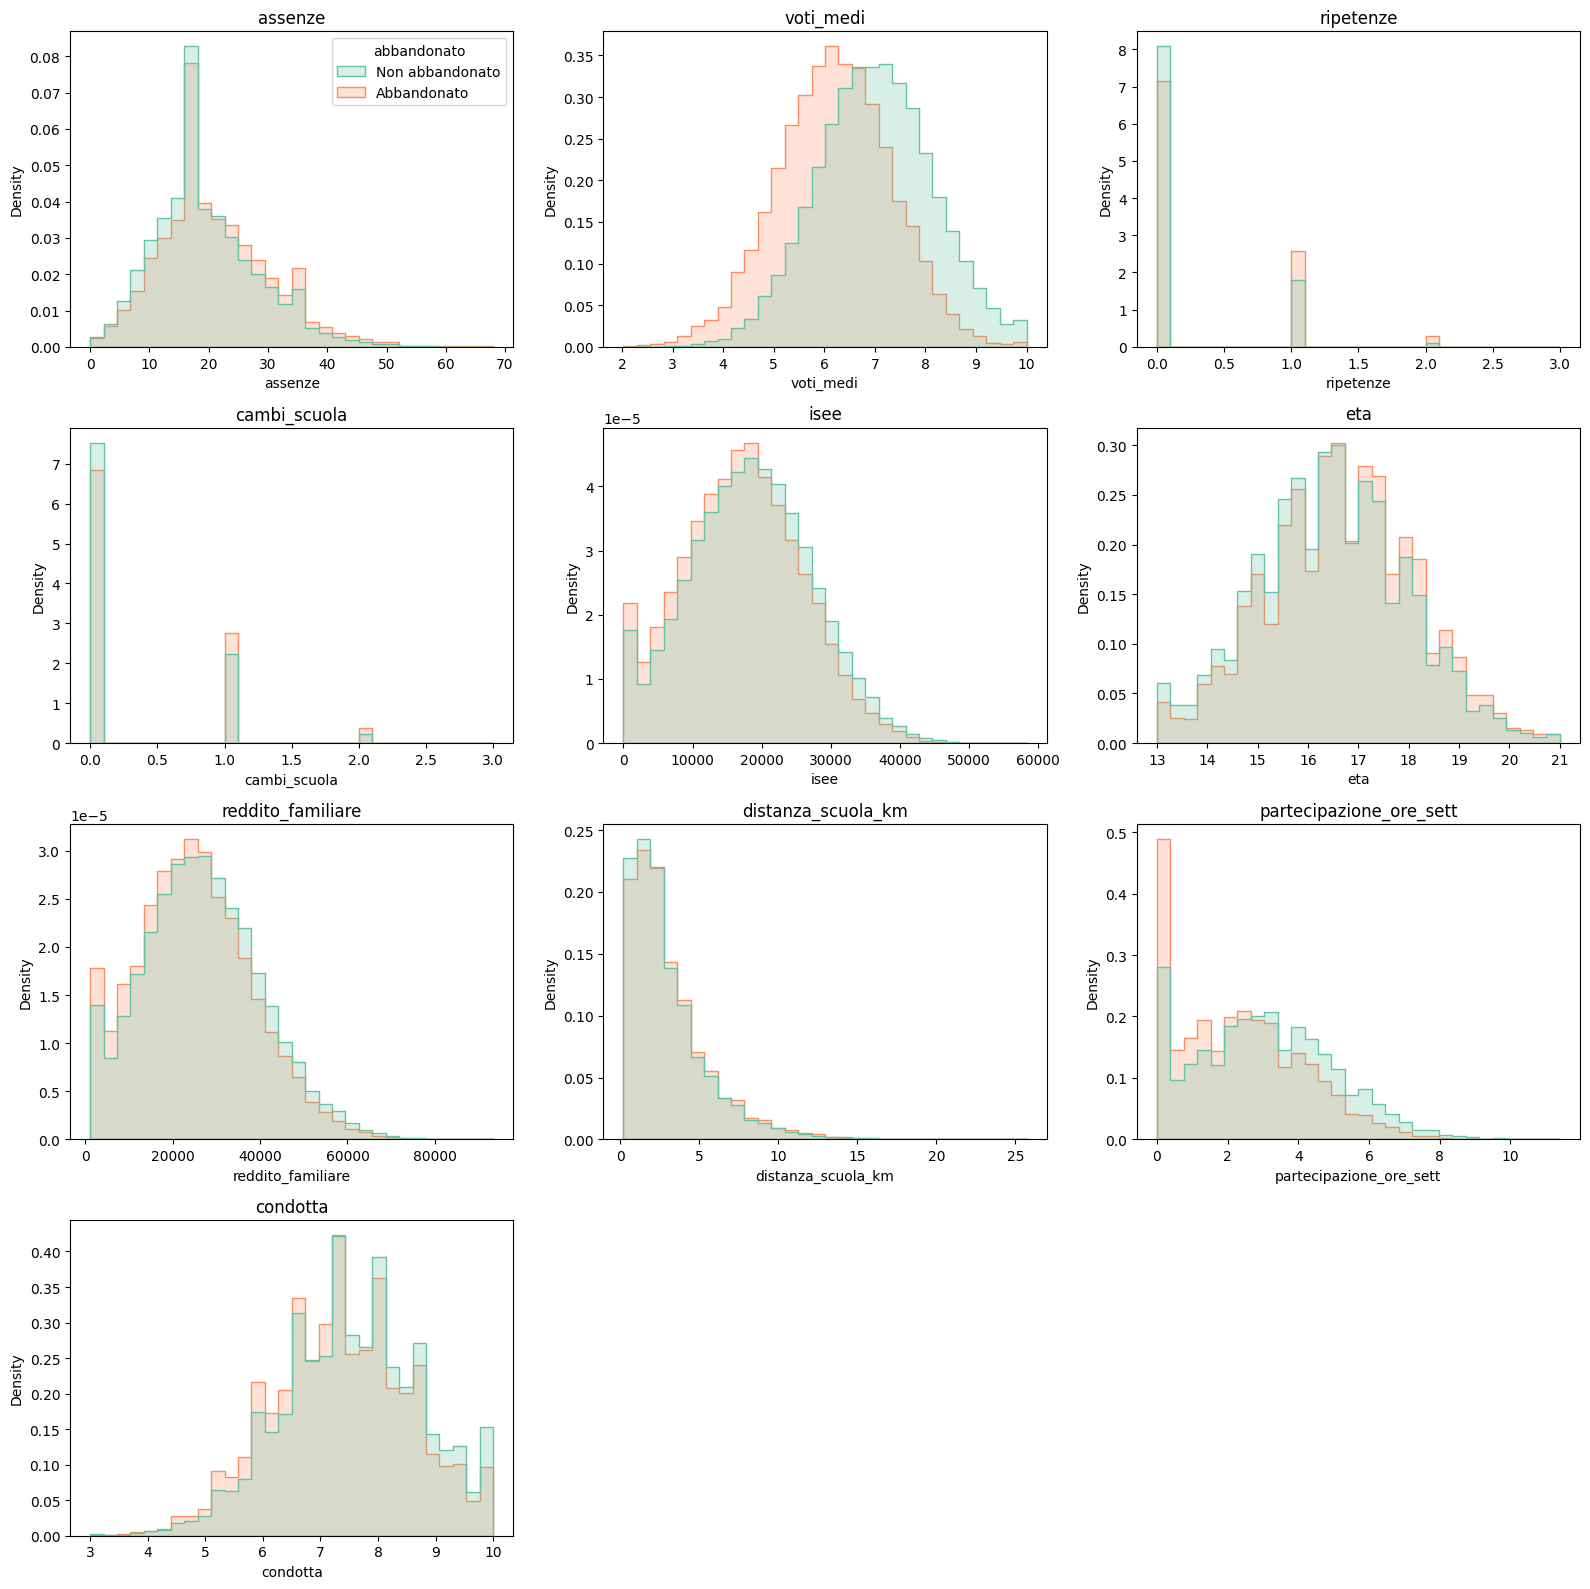

In [13]:

import math
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Parametri
target = "abbandonato"   # target corretto per il dataset scolastico
ncols = 3                # numero di colonne nella griglia

# ---- Crea una copia per il plotting
df_plot = df.copy()
if target not in df_plot.columns:
    raise ValueError(f"Target '{target}' non trovato. Colonne: {list(df_plot.columns)}")

# Mappa 0/1 in etichette leggibili
mapping = {0: "Non abbandonato", 1: "Abbandonato"}
df_plot[target] = df_plot[target].map(mapping)

# ---- Seleziona le colonne numeriche (esclude il target)
num_cols = df_plot.select_dtypes(include="number").columns.tolist()
if target in num_cols:
    num_cols.remove(target)

# ---- Crea la griglia
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.histplot(
        data=df_plot,
        x=col,
        hue=target,
        element="step",
        stat="density",
        common_norm=False,
        bins=30,
        palette="Set2",
        ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    if i != 0 and ax.get_legend() is not None:
        ax.get_legend().remove()

# Spegni gli assi vuoti
for j in range(len(num_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


##3) Train/Test split e preprocessing

Train set (~80%) → per addestrare i modelli.

Test set (~20%) → per valutare le prestazioni su dati mai visti.

In [14]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

RANDOM_STATE = 42
TARGET = "abbandonato"

# 1) Separazione X (feature) e y (target)
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# 2) Identifica tipi di variabili
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeriche:", len(num_features), "| Categoriali:", len(cat_features))

# 3) Train/Test split stratificato (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# 4) Preprocessing:
#    - numeriche → StandardScaler
#    - categoriali → OneHotEncoder (drop='first' per evitare multicollinearità)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_features),
    ],
    remainder="drop"
)

# 5) Pipeline (solo preprocessing qui; aggiungerai il modello dopo)
pipe = Pipeline(steps=[("preprocess", preprocess)])

# 6) Trasforma i dati (opzionale se userai pipe dentro un modello sklearn)
X_train_ready = pipe.fit_transform(X_train)
X_test_ready  = pipe.transform(X_test)

print("Train:", X_train_ready.shape, "| Test:", X_test_ready.shape)


Numeriche: 10 | Categoriali: 4
Train: (37055, 23) | Test: (9264, 23)


In [23]:
# ============================================
# RF veloce: tuning compatto + refit finale
# ============================================

# Progress bar (una tantum può installare i pacchetti)
try:
    from tqdm.auto import tqdm
    from tqdm_joblib import tqdm_joblib
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "tqdm", "tqdm_joblib"], check=True)
    from tqdm.auto import tqdm
    from tqdm_joblib import tqdm_joblib

import numpy as np, pandas as pd, joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# --- Parametri
CSV_PATH     = "abbandono_scolastico_100k.csv"
TARGET       = "abbandonato"
RANDOM_STATE = 42
SAMPLE_SIZE  = 40_000   # usa un campione per il tuning
N_ITER       = 12       # candidati
CV_FOLDS     = 3        # fold
TOTAL_FITS   = N_ITER * CV_FOLDS

# 1) Carica dati
df = pd.read_csv(CSV_PATH)
assert TARGET in df.columns, f"Target '{TARGET}' non trovato"
X_full = df.drop(columns=[TARGET]); y_full = df[TARGET].astype(int)

# 2) Campione per tuning
df_tune = df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE) if len(df) > SAMPLE_SIZE else df
X = df_tune.drop(columns=[TARGET]); y = df_tune[TARGET].astype(int)

# 3) Split per tuning
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# 4) Preprocess: solo One-Hot (RF non richiede scaling)
cat_cols = Xtr.select_dtypes(exclude=[np.number]).columns.tolist()
prep = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols)],
    remainder="passthrough"
)

# 5) Modello base: RF single-thread (evita parallelismo annidato)
rf = RandomForestClassifier(
    n_jobs=1,
    random_state=RANDOM_STATE,
    class_weight="balanced_subsample",
    bootstrap=True
)

pipe = Pipeline([("prep", prep), ("clf", rf)], memory="cache_dir")

# 6) Spazio iperparametri compatto (veloce)
param_dist = {
    "clf__n_estimators":      [120, 180, 240],
    "clf__max_depth":         [10, 14, 18],
    "clf__min_samples_split": [5, 10],
    "clf__min_samples_leaf":  [2, 4],
    "clf__max_features":      ["sqrt", "log2"],
}

# 7) RandomizedSearch con barra di avanzamento (parallelizza la CV)
search = RandomizedSearchCV(
    pipe, param_distributions=param_dist,
    n_iter=N_ITER, cv=CV_FOLDS, scoring="roc_auc",
    n_jobs=-1, pre_dispatch="2*n_jobs",
    random_state=RANDOM_STATE, verbose=0, error_score="raise"
)

with joblib.parallel_backend("threading"):
    with tqdm_joblib(tqdm(total=TOTAL_FITS, desc="CV fits")):
        search.fit(Xtr, ytr)

print("\n== Best ROC-AUC (CV) ==", round(search.best_score_, 3))
print("== Best params ==")
for k, v in search.best_params_.items():
    print(f"{k}: {v}")

# 8) Valutazione sul test del tuning-set
best_pipe = search.best_estimator_
yp  = best_pipe.predict(Xte)
ypp = best_pipe.predict_proba(Xte)[:,1]
print("\n=== Metriche (tuning test) ===")
print(f"Accuracy : {accuracy_score(yte, yp):.3f}")
print(f"Precision: {precision_score(yte, yp):.3f}")
print(f"Recall   : {recall_score(yte, yp):.3f}")
print(f"F1-score : {f1_score(yte, yp):.3f}")
print(f"ROC-AUC  : {roc_auc_score(yte, ypp):.3f}\n")
print("Matrice di confusione:\n", confusion_matrix(yte, yp))
print("\nReport:\n", classification_report(yte, yp, digits=3))

# 9) Refit finale su TRAIN dell'intero dataset con più alberi + parallelismo
Xf_tr, Xf_te, yf_tr, yf_te = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=RANDOM_STATE)
final_pipe = search.best_estimator_
final_pipe.set_params(clf__n_estimators=500, clf__n_jobs=-1)  # più alberi, ora parallelizza la RF
final_pipe.fit(Xf_tr, yf_tr)

# 10) Valutazione finale su test "hold-out" dell'intero dataset
y_pred  = final_pipe.predict(Xf_te)
y_proba = final_pipe.predict_proba(Xf_te)[:,1]
print("\n=== Metriche FINALi (hold-out) ===")
print(f"Accuracy : {accuracy_score(yf_te, y_pred):.3f}")
print(f"Precision: {precision_score(yf_te, y_pred):.3f}")
print(f"Recall   : {recall_score(yf_te, y_pred):.3f}")
print(f"F1-score : {f1_score(yf_te, y_pred):.3f}")
print(f"ROC-AUC  : {roc_auc_score(yf_te, y_proba):.3f}")

# 11) Salva modello e risultati CV
joblib.dump(final_pipe, "rf_best_fast.joblib")
pd.DataFrame(search.cv_results_).to_csv("cv_results_fast.csv", index=False)

print("\n✅ Fatto. Modello salvato come 'rf_best_fast.joblib' e risultati in 'cv_results_fast.csv'.")


CV fits:   0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


== Best ROC-AUC (CV) == 0.738
== Best params ==
clf__n_estimators: 240
clf__min_samples_split: 10
clf__min_samples_leaf: 4
clf__max_features: log2
clf__max_depth: 14

=== Metriche (tuning test) ===
Accuracy : 0.708
Precision: 0.534
Recall   : 0.574
F1-score : 0.553
ROC-AUC  : 0.745

Matrice di confusione:
 [[4215 1263]
 [1075 1447]]

Report:
               precision    recall  f1-score   support

           0      0.797     0.769     0.783      5478
           1      0.534     0.574     0.553      2522

    accuracy                          0.708      8000
   macro avg      0.665     0.672     0.668      8000
weighted avg      0.714     0.708     0.710      8000


=== Metriche FINALi (hold-out) ===
Accuracy : 0.707
Precision: 0.525
Recall   : 0.615
F1-score : 0.567
ROC-AUC  : 0.744

✅ Fatto. Modello salvato come 'rf_best_fast.joblib' e risultati in 'cv_results_fast.csv'.


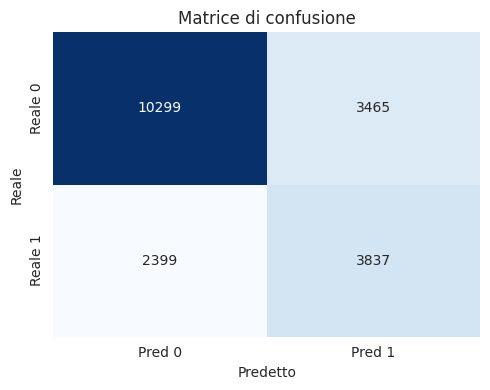

<Figure size 500x400 with 0 Axes>

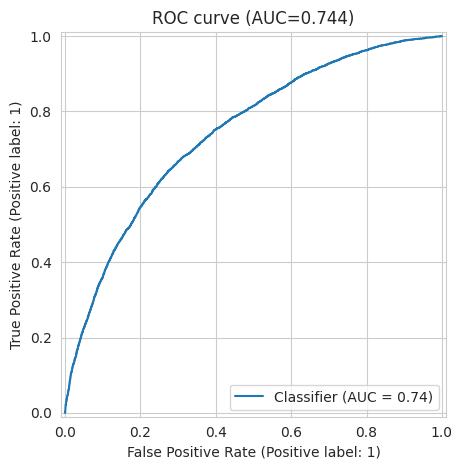

<Figure size 500x400 with 0 Axes>

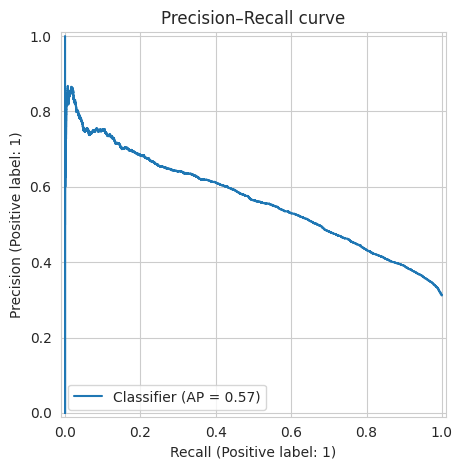

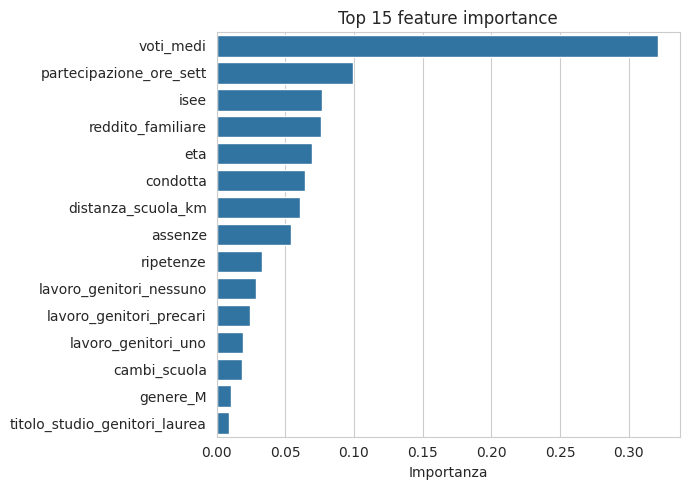

In [26]:
# =======================
# Grafici post-tuning (OK)
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score
)
from sklearn.inspection import permutation_importance

# --- usa SEMPRE la pipeline fittata
clf_pipe = best_pipe          # <- pipeline già fittata da RandomizedSearchCV
assert hasattr(clf_pipe, "predict"), "La pipeline non risulta fittata (manca .predict)."

# --- Predizioni
y_pred  = clf_pipe.predict(X_test)
y_proba = (clf_pipe.predict_proba(X_test)[:, 1]
           if hasattr(clf_pipe, "predict_proba")
           else clf_pipe.decision_function(X_test))

# 1) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0","Pred 1"], yticklabels=["Reale 0","Reale 1"])
plt.title("Matrice di confusione"); plt.xlabel("Predetto"); plt.ylabel("Reale")
plt.tight_layout(); plt.show()

# 2) ROC e PR
plt.figure(figsize=(5,4)); RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC curve (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4)); PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision–Recall curve")
plt.tight_layout(); plt.show()

# 3) Feature importance (RF: native; HGB: native, se non disponibile -> permutation)
# ---- ricostruisci i nomi delle feature DOPO il ColumnTransformer fittato
feat_names = []
prep = clf_pipe.named_steps.get("prep", None)
if prep is not None:
    # cat
    if "cat" in prep.named_transformers_:
        ohe = prep.named_transformers_["cat"]
        try:
            feat_names += ohe.get_feature_names_out(ohe.feature_names_in_).tolist()
        except Exception:
            # fallback se feature_names_in_ non disponibile
            feat_names += ohe.get_feature_names_out().tolist()
    # numeriche (pass-through): recupera dagli input originali quelli non categoriali
    orig_cols = X_test.columns.tolist()
    cat_cols = getattr(ohe, "feature_names_in_", []) if prep is not None else []
    num_cols = [c for c in orig_cols if c not in list(cat_cols)]
    feat_names += num_cols
else:
    # nessun preprocess: usa colonne originali
    feat_names = X_test.columns.tolist()

# ---- prova importanze native, altrimenti permutation importance
model = clf_pipe.named_steps.get("clf")
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
else:
    # permutation importance (più lento ma sicuro)
    r = permutation_importance(clf_pipe, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
    importances = r.importances_mean

# allinea dimensioni
feat_names = feat_names[:len(importances)]

fi = (pd.DataFrame({"feature": feat_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .head(15))

plt.figure(figsize=(7,5))
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Top 15 feature importance")
plt.xlabel("Importanza"); plt.ylabel("")
plt.tight_layout(); plt.show()


##XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:08:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:08:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


Best iteration: 137
=== Metriche su test ===
ROC-AUC : 0.749
Accuracy: 0.735
Precision: 0.633
Recall   : 0.353
F1-score : 0.453

Report:
               precision    recall  f1-score   support

           0      0.756     0.907     0.825     13764
           1      0.633     0.353     0.453      6236

    accuracy                          0.735     20000
   macro avg      0.695     0.630     0.639     20000
weighted avg      0.718     0.735     0.709     20000



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [15:08:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


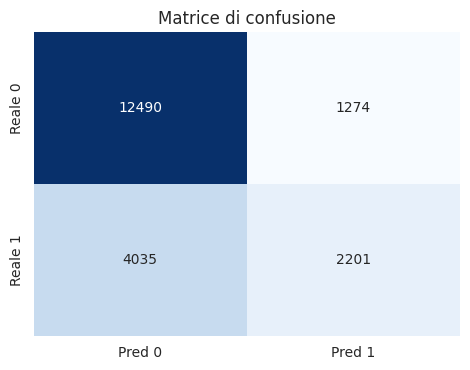

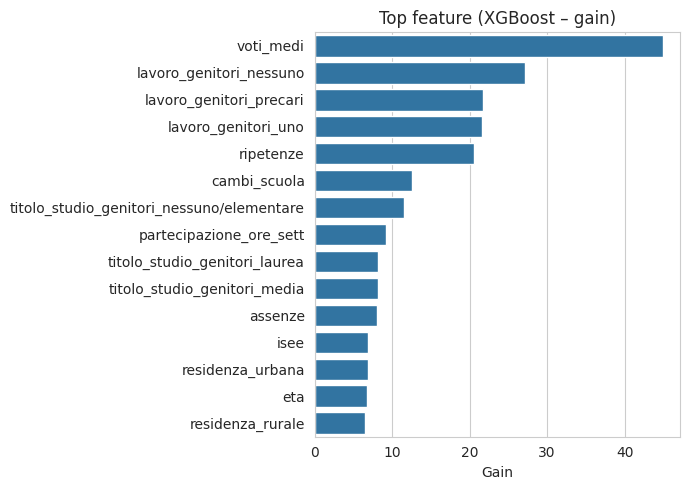

In [31]:
# ================================
# XGBoost GPU con DMatrix + early stopping (solo ISEE)
# ================================
import numpy as np, pandas as pd, scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report,
                             confusion_matrix)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

CSV_PATH = "abbandono_scolastico_100k.csv"
TARGET   = "abbandonato"
USE_GPU  = True  # T4 attiva

# 1) Load + tieni solo ISEE
df = pd.read_csv(CSV_PATH)
if "reddito_familiare" in df.columns:
    df = df.drop(columns=["reddito_familiare"])

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# 2) Split (train/valid/test)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.20, stratify=y_tr, random_state=42)

# 3) One-Hot (compatibile con tutte le versioni sklearn)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True)   # sklearn ≥1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=True)         # sklearn <1.2

ct = ColumnTransformer([("cat", ohe, X_tr.select_dtypes(exclude=[np.number]).columns.tolist())],
                       remainder="passthrough").fit(X_tr)

def tx(X_):
    Xt = ct.transform(X_)
    return sp.csr_matrix(Xt) if not sp.issparse(Xt) else Xt

X_tr_t, X_va_t, X_te_t = tx(X_tr), tx(X_va), tx(X_te)

# 4) DMatrix (necessario per xgb.train)
dtrain = xgb.DMatrix(X_tr_t, label=y_tr.values)
dvalid = xgb.DMatrix(X_va_t, label=y_va.values)
dtest  = xgb.DMatrix(X_te_t, label=y_te.values)

# 5) Parametri + early stopping
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 6,
    "min_child_weight": 2,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "tree_method": "gpu_hist" if USE_GPU else "hist",
    "predictor": "gpu_predictor" if USE_GPU else "auto",
    "verbosity": 1,
    "seed": 42,
}

num_boost_round = 3000
early_stopping_rounds = 50

watchlist = [(dtrain, "train"), (dvalid, "valid")]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False,   # metti True se vuoi il log ad ogni iter
)

print("Best iteration:", booster.best_iteration)

# 6) Valutazione su test
proba = booster.predict(dtest, iteration_range=(0, booster.best_iteration+1))
pred  = (proba >= 0.5).astype(int)

print("=== Metriche su test ===")
print(f"ROC-AUC : {roc_auc_score(y_te, proba):.3f}")
print(f"Accuracy: {accuracy_score(y_te, pred):.3f}")
print(f"Precision: {precision_score(y_te, pred):.3f}")
print(f"Recall   : {recall_score(y_te, pred):.3f}")
print(f"F1-score : {f1_score(y_te, pred):.3f}")
print("\nReport:\n", classification_report(y_te, pred, digits=3))

# 7) Confusion matrix (heatmap)
cm = confusion_matrix(y_te, pred)
plt.figure(figsize=(4.8,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0","Pred 1"], yticklabels=["Reale 0","Reale 1"])
plt.title("Matrice di confusione"); plt.tight_layout(); plt.show()

# 8) Top feature (gain) con nomi corretti
feat_names = []
if hasattr(ct.named_transformers_["cat"], "get_feature_names_out"):
    feat_names += ct.named_transformers_["cat"].get_feature_names_out(
        ct.named_transformers_["cat"].feature_names_in_
    ).tolist()
num_cols = [c for c in X.columns if c not in (ct.named_transformers_["cat"].feature_names_in_.tolist() if hasattr(ct.named_transformers_["cat"], "feature_names_in_") else [])]
feat_names += num_cols

scores = booster.get_score(importance_type="gain")  # {'f0': gain, ...}
idx_name = {f"f{i}": name for i, name in enumerate(feat_names)}
imp = (pd.DataFrame([(idx_name.get(k, k), v) for k, v in scores.items()],
                    columns=["feature","gain"])
         .sort_values("gain", ascending=False)
         .head(15))

plt.figure(figsize=(7,5))
sns.barplot(data=imp, x="gain", y="feature")
plt.title("Top feature (XGBoost – gain)"); plt.xlabel("Gain"); plt.ylabel("")
plt.tight_layout(); plt.show()


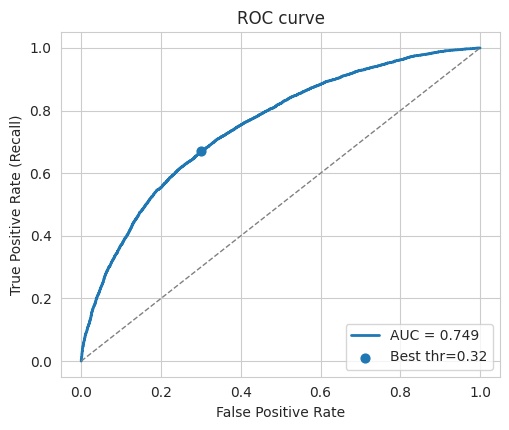

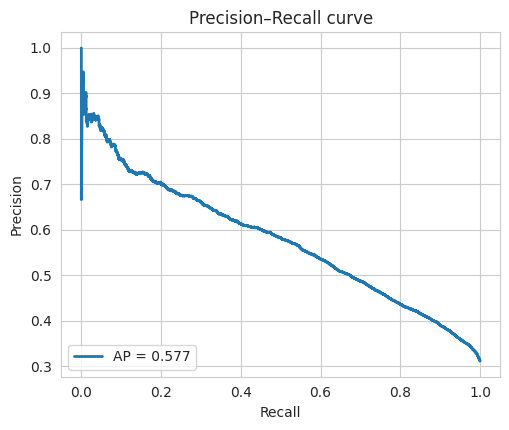

In [32]:
# ================================
# ROC curve (e PR curve opzionale)
# ================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Se non hai già 'proba' e 'y_te', decommenta la riga sotto:
# proba = booster.predict(dtest, iteration_range=(0, booster.best_iteration+1))

# --- ROC
fpr, tpr, thr = roc_curve(y_te, proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5.2,4.4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], "--", lw=1, color="gray")
# Punto ottimale (Youden J)
j = np.argmax(tpr - fpr)
plt.scatter(fpr[j], tpr[j], s=40, marker="o", label=f"Best thr={thr[j]:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- (Opzionale) Precision–Recall curve
prec, rec, thr_pr = precision_recall_curve(y_te, proba)
ap = average_precision_score(y_te, proba)

plt.figure(figsize=(5.2,4.4))
plt.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


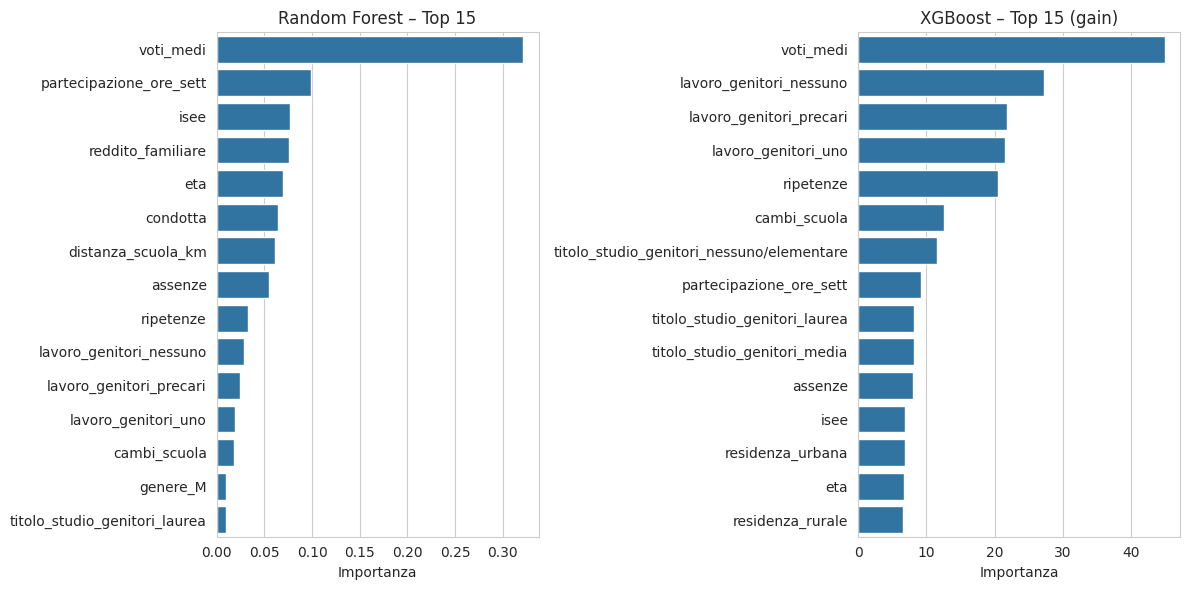


Top 15 – Random Forest
                      feature  importance
                    voti_medi    0.321255
      partecipazione_ore_sett    0.099012
                         isee    0.076683
            reddito_familiare    0.076093
                          eta    0.069711
                     condotta    0.063989
           distanza_scuola_km    0.060857
                      assenze    0.054459
                    ripetenze    0.033210
      lavoro_genitori_nessuno    0.028728
      lavoro_genitori_precari    0.024571
          lavoro_genitori_uno    0.018897
                 cambi_scuola    0.018635
                     genere_M    0.010359
titolo_studio_genitori_laurea    0.009390

Top 15 – XGBoost (gain)
                                  feature  importance
                                voti_medi   44.897152
                  lavoro_genitori_nessuno   27.206995
                  lavoro_genitori_precari   21.788511
                      lavoro_genitori_uno   21.532946
         

In [34]:
# ============================================
# Confronto Feature Importance: RF vs XGBoost
# ============================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import xgboost as xgb

# --- recupera X_test comune
X_test_common = X_test if 'X_test' in globals() else X_te

# --- helper: estrai i nomi delle feature da un ColumnTransformer fittato
def feature_names_from_ct(ct, input_cols):
    # Prova API moderna
    try:
        names = ct.get_feature_names_out()
        # rimuovi prefissi tipo "cat__"
        names = [n.split("__", 1)[-1] for n in names]
        return names
    except Exception:
        # Fallback: OHE (cat) + numeriche pass-through
        names = []
        if "cat" in ct.named_transformers_:
            ohe = ct.named_transformers_["cat"]
            try:
                base = ohe.feature_names_in_
            except Exception:
                base = []
            names += ohe.get_feature_names_out(base).tolist()
            cat_list = list(base)
        else:
            cat_list = []
        num_cols = [c for c in input_cols if c not in cat_list]
        names += num_cols
        return names

# ---------- 1) IMPORTANZE RANDOM FOREST ----------
prep_rf = best_pipe.named_steps.get("prep")
rf_model = best_pipe.named_steps.get("clf")

# prova a prendere i nomi direttamente dal CT della pipeline RF
try:
    rf_feat_names = feature_names_from_ct(prep_rf, X_test_common.columns.tolist())
except Exception:
    # fallback: prova a usare i nomi dal CT di XGB (se identico)
    rf_feat_names = feature_names_from_ct(ct, X_test_common.columns.tolist())

rf_importances = rf_model.feature_importances_
fi_rf = (pd.DataFrame({"feature": rf_feat_names[:len(rf_importances)],
                       "importance": rf_importances})
         .sort_values("importance", ascending=False)
         .head(15))

# ---------- 2) IMPORTANZE XGBOOST ----------
# nomi delle colonne nell'ordine dato a DMatrix (cioè ct.transform)
xgb_feat_names = feature_names_from_ct(ct, X_test_common.columns.tolist())

# booster.get_score restituisce solo le feature usate (f0, f1, ...)
scores = booster.get_score(importance_type="gain")
imp_vals = [scores.get(f"f{i}", 0.0) for i in range(len(xgb_feat_names))]
fi_xgb = (pd.DataFrame({"feature": xgb_feat_names, "importance": imp_vals})
          .sort_values("importance", ascending=False)
          .head(15))

# ---------- 3) PLOT affiancati ----------
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False)

sns.barplot(data=fi_rf, x="importance", y="feature", ax=axes[0])
axes[0].set_title("Random Forest – Top 15")
axes[0].set_xlabel("Importanza"); axes[0].set_ylabel("")

sns.barplot(data=fi_xgb, x="importance", y="feature", ax=axes[1])
axes[1].set_title("XGBoost – Top 15 (gain)")
axes[1].set_xlabel("Importanza"); axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

# ---------- 4) Tabelle (opzionali) ----------
print("\nTop 15 – Random Forest")
print(fi_rf.to_string(index=False))

print("\nTop 15 – XGBoost (gain)")
print(fi_xgb.to_string(index=False))


Rendimento scolastico è il driver principale → supporto su voti e partecipazione.

Contesto familiare (disoccupazione/precariato, basso titolo di studio) pesa: strumenti di sostegno e tutoring mirato.

Storia scolastica (ripetenze, cambi) segnala rischio: monitoraggio precoce.

ISEE vs reddito: ridondanti; tenere solo ISEE semplifica senza perdere molto.

##MLPClassifier

=== Metriche test (MLP) ===
Accuracy : 0.738
Precision: 0.627
Recall   : 0.393
F1-score : 0.483
ROC-AUC  : 0.753

Report:
               precision    recall  f1-score   support

           0      0.765     0.894     0.824     13764
           1      0.627     0.393     0.483      6236

    accuracy                          0.738     20000
   macro avg      0.696     0.643     0.654     20000
weighted avg      0.722     0.738     0.718     20000



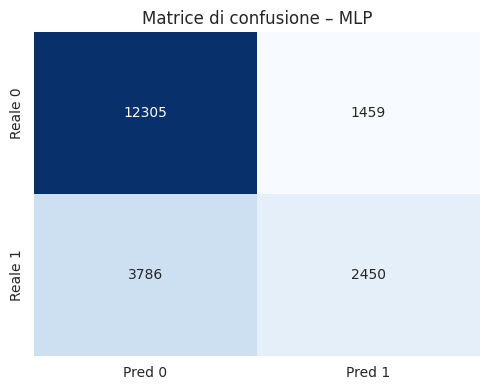

<Figure size 500x400 with 0 Axes>

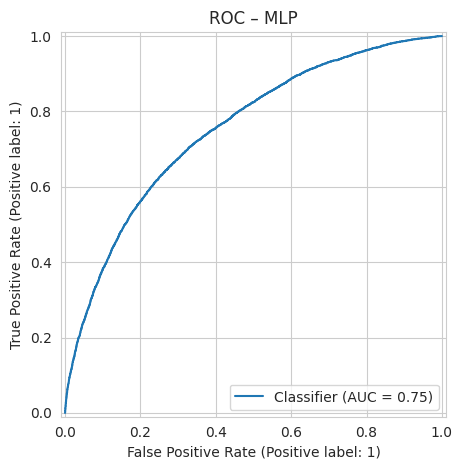

<Figure size 500x400 with 0 Axes>

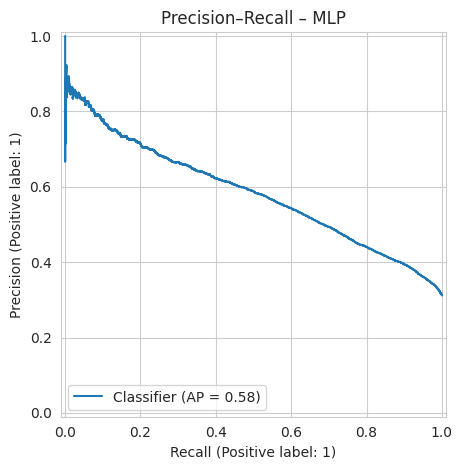

In [36]:
# ============================================
# MLPClassifier (rete neurale semplice) – OK
# ============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

CSV_PATH = "abbandono_scolastico_100k.csv"
TARGET   = "abbandonato"

# 1) Load
df = pd.read_csv(CSV_PATH)
# (se vuoi tenere solo ISEE)
if {"isee","reddito_familiare"}.issubset(df.columns):
    df = df.drop(columns=["reddito_familiare"])

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 3) Preprocess (denso: MLP non accetta sparse)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)  # sklearn ≥1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)        # sklearn <1.2

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

# 4) Modello
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-4,                # L2
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=10,
    random_state=42
)

pipe = Pipeline([("prep", preprocess), ("clf", mlp)])

# 5) Train (⚠️ niente sample_weight in questa versione)
pipe.fit(X_train, y_train)

# 6) Valutazione
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("=== Metriche test (MLP) ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
print(f"F1-score : {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_proba):.3f}\n")
print("Report:\n", classification_report(y_test, y_pred, digits=3))

# 7) Grafici rapidi
sns.set_style("whitegrid")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0","Pred 1"], yticklabels=["Reale 0","Reale 1"])
plt.title("Matrice di confusione – MLP"); plt.tight_layout(); plt.show()

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
plt.figure(figsize=(5,4)); RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC – MLP"); plt.tight_layout(); plt.show()
plt.figure(figsize=(5,4)); PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision–Recall – MLP"); plt.tight_layout(); plt.show()


In [44]:
# --- Calcola proba_mlp sullo STESSO test di y_true ---
import pandas as pd

CSV_PATH = "abbandono_scolastico_100k.csv"

# ricarico il CSV per avere tutte le colonne che il MLP si aspetta
df_all = pd.read_csv(CSV_PATH)

# indici del test usato in y_true
idx = y_true.index if hasattr(y_true, "index") else pd.RangeIndex(len(y_true))

# colonne attese dal MLP (pipeline 'pipe')
cols_mlp = pipe.named_steps["prep"].feature_names_in_
X_mlp = df_all.loc[idx, cols_mlp]

# probabilità positive del MLP
proba_mlp = pipe.predict_proba(X_mlp)[:, 1]


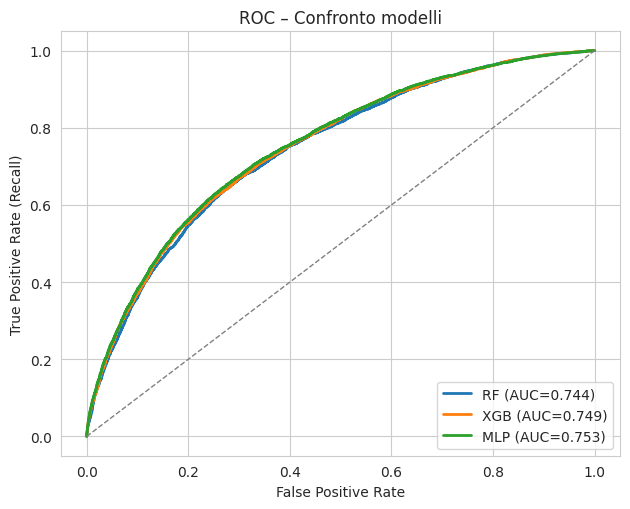

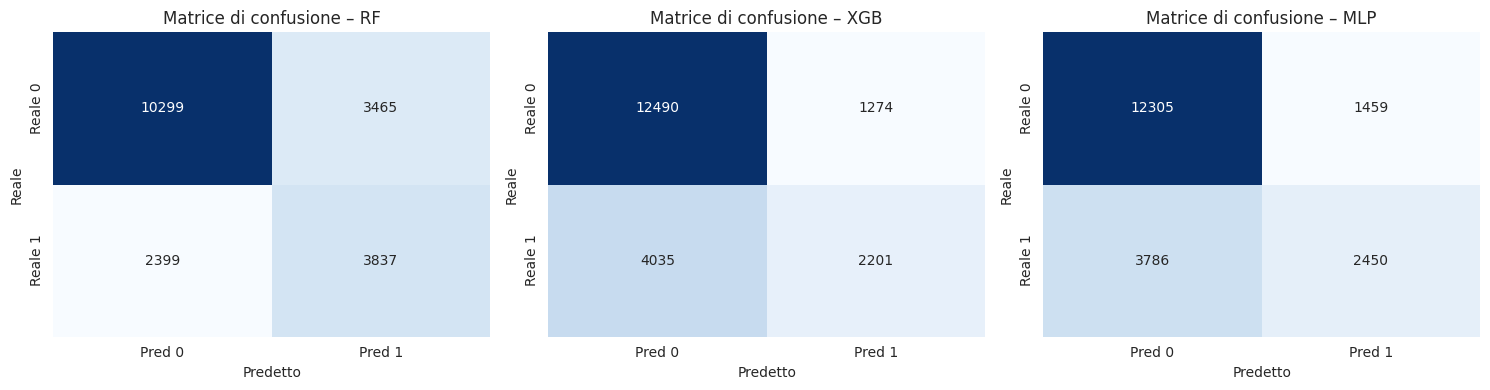

In [45]:
# ============================================
# Overlay ROC + Confusion usando variabili esistenti
# (auto-rilevamento nomi: y_test / y_te, proba_* di RF/XGB/MLP)
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# --- helper per trovare una variabile tra alias noti
def pick(alias_list, g=globals()):
    for a in alias_list:
        if a in g:
            return g[a]
    return None

# 1) y_true
y_true = pick(["y_true", "y_test", "y_te", "y_common"])
if y_true is None:
    raise RuntimeError("Non trovo il vettore delle etichette: definisci y_true (o y_test / y_te).")

# 2) probabilità dei modelli (metti qui eventuali tuoi alias aggiuntivi)
probas = {}
aliases = {
    "RF":  ["proba_rf", "y_proba_rf", "rf_proba", "proba_RF", "proba_random_forest"],
    "XGB": ["proba_xgb", "y_proba_xgb", "xgb_proba", "proba_xgboost"],
    "MLP": ["proba_mlp", "y_proba_mlp", "mlp_proba"],
}
for name, alist in aliases.items():
    v = pick(alist)
    if v is not None:
        probas[name] = np.asarray(v)

if not probas:
    raise RuntimeError("Non trovo nessuna proba (proba_rf / proba_xgb / proba_mlp).")

# 3) ROC overlay
plt.figure(figsize=(6.4, 5.2))
for name, p in probas.items():
    fpr, tpr, _ = roc_curve(y_true, p)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray", lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC – Confronto modelli")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

# 4) Matrici di confusione (soglia 0.5)
sns.set_style("whitegrid")
n = len(probas)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
for ax, (name, p) in zip(axes.ravel(), probas.items()):
    yhat = (p >= 0.5).astype(int)
    cm = confusion_matrix(y_true, yhat)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0","Pred 1"], yticklabels=["Reale 0","Reale 1"], ax=ax)
    ax.set_title(f"Matrice di confusione – {name}")
    ax.set_xlabel("Predetto"); ax.set_ylabel("Reale")
plt.tight_layout(); plt.show()


Scelta consigliata

Per uso reale (early-warning) → XGBoost: più stabile di MLP, sfrutta la GPU T4, buona precision a 0.5 e AUC alta.
Poi abbassa la soglia per portare il recall al livello desiderato (es. 0.60) mantenendo più precisione di RF a pari recall, grazie all’AUC superiore.

Baseline semplice → RF (subito buono sul recall senza tuning di soglia).

MLP lo terrei come sperimentale: AUC leggermente migliore, ma meno interpretabile/stabile e solo CPU.

In breve: metterei XGBoost in produzione, RF come confronto, MLP per test.
